# Geospatial Big Data Analysis - Lab 2

**Konstantinos Papadakis**

Student of Msc Data Science and Machine Learning (ID: 03400149)

k.i.papadakis@gmail.com

## Step 1

First we import the raster data about Kastoria, as well one polygon defining our area of interest (`aoi`). We also import weather data about a single point in our area of interest.

Sadly, I could not find a WFS service for Corine Land Rover in Greece. I did find one for a region of Switzerland though, and I will utilize in Step 3.

In [1]:
import datetime

import numpy as np
import shapely
import fiona
import geojson
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.warp
import matplotlib.pyplot as plt
import requests
import leafmap

In [2]:
sentinel_path = 'Kastoria/Kastoria.tif'
corine_path = 'Kastoria/Kast_RefData_26Classes.tif'
aoi_old_path = 'map.geojson'
aoi_new_path = 'map-correct-crs.geojson'
weather_path = 'weather.json'

image_names = [
    '2016-01-25',
    '2016-02-14',
    '2016-03-28',
    '2016-04-04',
    '2016-04-27',
    '2016-06-06',
    '2016-07-03',
    '2016-07-13',
    '2016-07-23',
    '2016-07-26',
    '2016-08-05',
    '2016-08-12',
    '2016-08-15',
    '2016-08-22',
    '2016-09-04',
    '2016-09-14',
    '2016-10-01',
    '2016-10-14',
    '2016-11-13',
    '2016-12-03',
    '2016-12-10',
    '2016-12-20',
    '2016-12-23',
    '2016-12-30'
]

band_names = [
    'blue',
    'green',
    'red',
    'nir',
    'swir1',
    'swir2',
    'ndvi',
    'msavi',
    'ndwi',
    'ndbi'
]

# sentinel = rasterio.open(sentinel_path)
# corine = rasterio.open(corine_path)
# weather = gpd.read_file(weather_path)
# weather.parameter[0].keys()

## Step 2

We now read the first image of out dataset and display it in RGB.

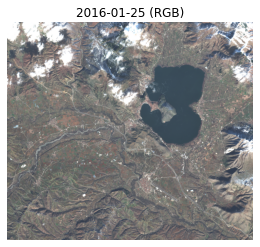

In [3]:
# PLOT RGB

n_bands = 10
n_images = 24
rgb_bands = [3, 2, 1]
with rasterio.open(sentinel_path) as sentinel:
    rgb_sentinel = sentinel.read(rgb_bands)  # Image of the first date
rgb_sentinel = rgb_sentinel.transpose((1, 2, 0))
plt.imshow(rgb_sentinel)
plt.axis('off')
plt.title('2016-01-25 (RGB)')
plt.show()

We proceed to clip images using our region of interest and then we display the NDVI band of the result.

In [4]:
# CLIP THE DATA

# Read the aoi with geopandas, change the coordinates to match the raster, write in a new file,
# load that file and use it to clip the data.
g = gpd.read_file(aoi_old_path)
with rasterio.open(sentinel_path) as sentinel:
    sentinel_crs = sentinel.crs.to_epsg()
    g = g.to_crs(epsg=sentinel_crs)
    g.to_file(aoi_new_path, driver="GeoJSON")

    with fiona.open(aoi_new_path) as gj:
        aoi = [feature['geometry'] for feature in gj]
        aoi_crs = gj.crs

    masked, masked_transform = rasterio.mask.mask(
        sentinel, aoi, crop=True,
        nodata=np.nan  # important for computing the mean
    )

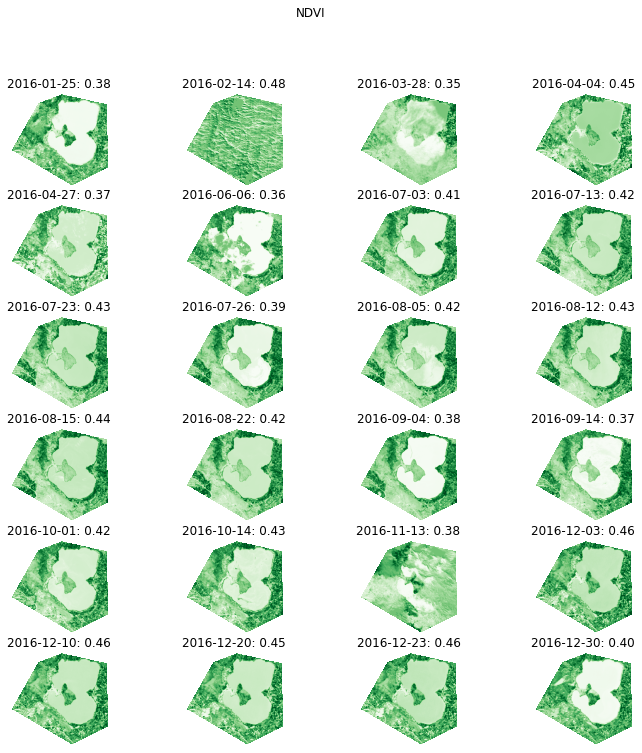

In [5]:
# PLOT NDVI IMAGES

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(12, 12))
band = 7  # NDVI
cmap = 'Greens'
img_means = []
for ax, (image_id, image_name) in zip(axs.flat, enumerate(image_names, 1)):
    image_band_idx = (image_id - 1) * n_bands + band
    img = masked[image_band_idx]
    img_mean = np.nanmean(img)  # np.nanmean ignores nan values
    img_means.append(img_mean)
    ax.imshow(img, cmap=cmap)
    ax.set_axis_off()
    ax.set_title(f'{image_name}: {img_mean:.2f}')

fig.suptitle('NDVI')
plt.show()

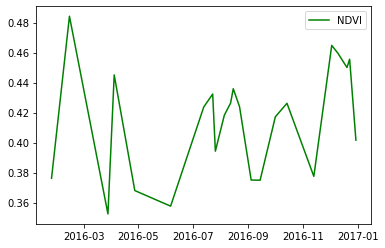

In [6]:
# PLOT NDVI AVERAGE

plt.plot(
    [datetime.date.fromisoformat(image_name) for image_name in image_names],
    img_means,
    color='green',
    label='NDVI'
)
plt.legend()
plt.show()

## Step 3

In this step we use vector data to explore relations between schools, police departments and churches over the various administrative regions of Athens (I could not find vector data for Kastoria).


In [7]:
# FETCH THE DATA

def wfs_geodatagov(typeName, crs):
    url = 'http://geodata.gov.gr/geoserver/ows'
    params = dict(service='WFS', version='2.0.0', request='GetFeature', srsName=f'EPSG:{crs}', outputFormat='json')
    params['typeName'] = typeName
    r = requests.get(url, params=params)
    features = geojson.loads(r.text)
    df = gpd.GeoDataFrame.from_features(features, crs=crs)
    return df


# EPGS:32634 uses meters for coordinates, which means we can conviniently use meters as buffer distance
crs = 32634
police_typeName = 'geodata.gov.gr:9603c9bb-fa1c-4272-beb5-2a21204da56b'
schools_typeName = 'geodata.gov.gr:11009351-71ec-47f1-9da5-282f04b72a80'
churches_typeName = 'geodata.gov.gr:8ae90a8d-ab68-4c0a-8153-45cab12ee57a'

police = wfs_geodatagov(police_typeName, crs)
schools = wfs_geodatagov(schools_typeName, crs)
churches = wfs_geodatagov(churches_typeName, crs)

athens = gpd.read_file('dasynoikies')
athens = athens.to_crs(crs)

Percentage of schools within 400 meters of a church:  93.89%


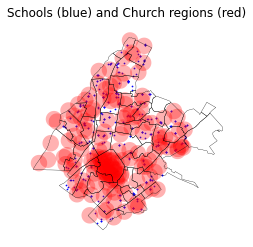

In [8]:
# PLOT CHURCH REGIONS AND SCHOOLS

fig, ax = plt.subplots()
athens.boundary.plot(ax=ax, color='black', linewidth=0.3)
schools.plot(ax=ax, color='blue', markersize=0.5)
churches.buffer(400).plot(ax=ax, alpha=0.3, color='red')
ax.set_title('Schools (blue) and Church regions (red)')
ax.set_axis_off()

schools_near_church = schools.within(churches.buffer(400).unary_union).mean()
print(f'Percentage of schools within 400 meters of a church: {schools_near_church: .2%}')

 13.70% of the Athens region does not have a school within 500 m


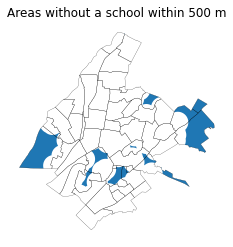

In [9]:
# PLOT AREAS WITHOUT A SCHOOL NEARBY

no_schools_nearby = athens.unary_union.difference(schools.buffer(500).unary_union)
ax = gpd.GeoSeries({'geometry': no_schools_nearby}).plot()
athens.exterior.plot(ax=ax, color='black', linewidth=0.2)
ax.set_title('Areas without a school within 500 m')
ax.set_axis_off()
no_schools_nearby_percent = no_schools_nearby.area / athens.unary_union.area
print(f'{no_schools_nearby_percent: .2%} of the Athens region does not have a school within 500 m')

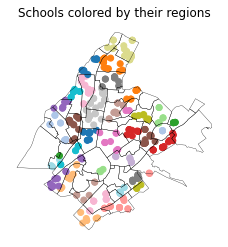

In [10]:
# FIND THE REGION OF EACH SCHOOL

# Find the administrative region of each school
joined = schools.sjoin(athens, how='inner', predicate='intersects')
# Plot the schools and color them according to their region
fig, ax = plt.subplots()
athens.boundary.plot(color='black', linewidth=0.3, ax=ax)
joined.plot(column='SINIKIA_EN', cmap='tab20', ax=ax)
ax.set_axis_off()
ax.set_title('Schools colored by their regions')
plt.show()

We now use a WFS service to fetch Corine Land Rover 2018 vector data for a region in Switzerland (I could not find one for Greece).

We also import an area of interest as well as weather data for a single point in that area.

Then we display those regions on a map and we create a time series plot to visualize the weather data.

In [11]:
# FETCH CORINE LAND ROVER 2018 VECTOR DATA

url = 'https://sdi.georhena.eu/geoserver/georhena/wfs'
params = dict(
    service='WFS', version='2.0.0', request='GetFeature',
    # srsName='EPSG:3035',
    outputFormat='json', typename='georhena:CLC_2018_CRS_ORK',
)
r = requests.get(url, params=params)
df = gpd.GeoDataFrame.from_features(geojson.loads(r.text), crs='EPSG:3035').to_crs(crs)
del r

In [12]:
# ADD A COLOR COLUMN

# Import Corine colors and change their form from decimal ddd-ddd-ddd to hexadecimal #xxxxxxxx
# then create a mapping and use it to map the corine color codes to normal color values.

def to_hex2(s: str) -> str:
    return hex(int(s))[2:].zfill(2)

clc_legend = pd.read_csv('clc_legend.csv')
clc_legend = clc_legend.dropna(subset=['RGB'])
clc_legend['RGB_HEX'] = clc_legend['RGB'].str.split('-').map(lambda lst: '#' + ''.join(map(to_hex2, lst)))
clc_legend['CLC_CODE'] = clc_legend['CLC_CODE'].astype(int).astype(str)

code_to_color = dict(zip(clc_legend['CLC_CODE'], clc_legend['RGB_HEX']))

df['color'] = df['code_18'].map(code_to_color.get)


In [13]:
aoi_alt_path = 'map-alt.geojson'
aoi_alt = gpd.GeoDataFrame.from_file(aoi_alt_path).to_crs(crs)

weather_alt_path = 'weather-alt.json'
weather_alt = gpd.GeoDataFrame.from_file(weather_alt_path).to_crs(crs)

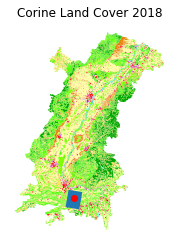

In [14]:
# DISPLAY THE VECTOR DATA ON THE MAP

ax = df.plot(color=df['color'])
aoi_alt.plot(ax=ax)
weather_alt.plot(ax=ax, color='red')
ax.set_axis_off()
ax.set_title('Corine Land Cover 2018')
plt.show()

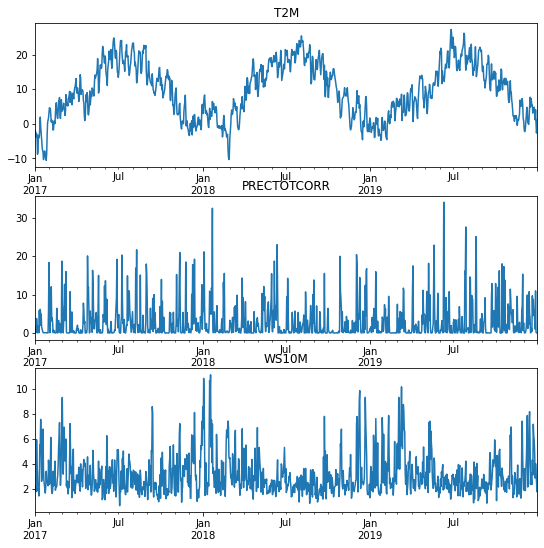

In [15]:
# VISUALIZE TIME SERIES OF WEATHER DATA

wdf = pd.DataFrame.from_dict(weather_alt.parameter[0])
wdf.index = pd.to_datetime(wdf.index)

fig, axs = plt.subplots(len(wdf.columns), figsize=(9, 9))

for col, ax in zip(wdf.columns, axs.flat):
    wdf.loc['2017':'2019', col].plot(ax=ax)
    ax.set_title(col)

## Step 4

In this step we create an interactive map containing Corine Land Rover 2018 data (from a WMS service) as well as Athens administrative regions and churches.

In [16]:
# CREATE AND DISPLAY AN INTERACTIVE MAP

url = 'https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2018_WM/MapServer/WMSServer?'
corine_layer = '12'

m = leafmap.Map()
m.add_wms_layer(
    url=url, layers='12', name='Corine Land Cover', format='image/png', shown=True
)

m.add_shp('dasynoikies/dasynoikies.shp', 'Athens Regions')

# m.add_gdf(police, 'Athens Police Departments')
# m.add_gdf(schools, 'Athens Schools')
m.add_gdf(churches, 'Athens Churches')

m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…